In this notebook, I will show how to train the TensorFlow version of Sketch-RNN on a new dataset, and convert the weights of the TF model to a JSON format that is usable by Sketch-RNN-JS so that interactive web demos can be built.

For the purpose of this tutorial, I will be training on the dataset file called `kanji.rdp25.npz` which is available inside the repo `https://github.com/hardmaru/sketch-rnn-datasets/` under the `kanji` subdirectory. If you have a custom dataset, you will need to convert it over to an .npz file using the stroke-3 format as done for these datasets. Please study the README.md in Sketch-RNN to understand how the file format that Sketch-RNN can work with work, in the section called ["Creating Your Own Dataset"](https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/README.md).

After cloning the TensorFlow repo for the Sketch-RNN [model](https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn), below is the command that I ran to train the TensorFlow model:

```
python sketch_rnn_train.py --data_dir=kanji --hparams=data_set=['kanji.rdp25.npz'],num_steps=200000,conditional=0,dec_rnn_size=1024
```

I store the `kanji.rdp25.npz` inside the subdirectory called `kanji` but you can use whatever you want. The important thing to note here is that I'm trainining a decoder-only model by setting `conditional=0` and I'm training a 1 layer LSTM with hidden size of 1024, which should be good enough for most datasets in the order of 10K size. Using 200K steps should take around half a day on a single P100 GPU, so it should cost around USD 10 dollars using the current prices for Google Cloud Platform to train this model.

After the model is trained, I run the remaining commands for this IPython notebook to generate a file call `custom.gen.json`, which can be used in the Sketch-RNN-JS repo for interactive work:

https://github.com/tensorflow/magenta-demos/tree/master/sketch-rnn-js

This `json` format created will also work for future TensorFlow.js and ML5.js versions of sketch-RNN.

In [2]:
# import the required libraries
import numpy as np
import time
import random

import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [3]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.12.0


In [6]:
import os
os.chdir(r'D:\playground\projects\magenta_pjt')

In [7]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *


# If code is modified to remove magenta dependencies:
'''
from sketch_rnn_train import *
from model import *
from utils import *
from rnn import *
'''

'\nfrom sketch_rnn_train import *\nfrom model import *\nfrom utils import *\nfrom rnn import *\n'

In [8]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename='/tmp/sketch_rnn/svg/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))


# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max + x_min) * 0.5
        return x_start - center_loc, x_end

    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0] * grid_space + grid_space * 0.5
        grid_x = grid_loc[1] * grid_space_x + grid_space_x * 0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x + loc_x
        new_y_pos = grid_y + loc_y
        result.append([new_x_pos - x_pos, new_y_pos - y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos + delta_pos[0]
        y_pos = new_y_pos + delta_pos[1]
    return np.array(result)


define the path of the model you want to load, and also the path of the dataset

In [34]:
# you may need to change these to link to where your data and checkpoints are actually stored!
# in the default config, model_dir is likely to be /tmp/sketch_rnn/models
subject = 'circle'

# data_dir = './kanji'
data_dir = r'D:\playground\projects\magenta_pjt\data_{}'.format(subject)
# model_dir = './log'
model_dir = r'D:\playground\projects\magenta_pjt\checkpoints_{}'.format(subject)

In [35]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

3
4
INFO:tensorflow:Loaded 8000/500/500 from circle.npz
INFO:tensorflow:Dataset combined: 9000 (8000/500/500), avg len 25
INFO:tensorflow:model_params.max_seq_len 30.
total images <= max_seq_len is 8000
total images <= max_seq_len is 500
total images <= max_seq_len is 500
INFO:tensorflow:normalizing_scale_factor 54.1372.


In [36]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [37]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [38]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [91]:
sess

In [39]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes


In [40]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model D:\playground\projects\magenta_pjt\checkpoints_circle\vector-4500.
INFO:tensorflow:Restoring parameters from D:\playground\projects\magenta_pjt\checkpoints_circle\vector-4500


In [118]:
file_path = r'D:\playground\projects\magenta_pjt\data_slime\slime.npz'
data = np.load(file_path, encoding='bytes')
data.files
data_train = data['train']  # drawings

In [ ]:
d = data_train[0]

In [124]:
draw_strokes(make_grid_svg([d]))

IndexError: too many indices for array

In [131]:
d

array([[ -23,    0,    0],
       [-133,    0,    0],
       [ -24,    6,    0],
       [ -30,   15,    0],
       [ -34,   24,    0],
       [ -71,   74,    0],
       [ -28,   47,    0],
       [ -28,   64,    0],
       [ -16,   53,    0],
       [  -7,   48,    0],
       [  -3,   78,    0],
       [   8,   19,    0],
       [  18,   20,    0],
       [  48,   30,    0],
       [  29,    7,    0],
       [ 147,   20,    0],
       [ 104,   -3,    0],
       [ 109,  -20,    0],
       [  69,  -25,    0],
       [  35,  -18,    0],
       [  79,  -51,    0],
       [  27,  -14,    0],
       [  22,  -20,    0],
       [  15,  -17,    0],
       [  16,  -45,    0],
       [   4,  -66,    0],
       [  -2,  -23,    0],
       [ -16,  -40,    0],
       [ -25,  -37,    0],
       [ -17,  -13,    0],
       [ -20,  -10,    0],
       [-131,  -51,    0],
       [ -23,  -13,    0],
       [ -28,   -8,    0],
       [ -22,    0,    1],
       [-209,  100,    0],
       [  -4,   -4,    0],
 

In [138]:
reconstructions[4]

[array([[-0.41247782, -0.02958624,  0.        ],
        [-0.73901737, -0.15296017,  0.        ],
        [-0.88306093, -0.30013621,  0.        ],
        [-0.81089985, -0.4991672 ,  0.        ],
        [-0.71412736, -0.66217732,  0.        ],
        [-0.52940011, -0.75249565,  0.        ],
        [ 0.15056928, -1.79465342,  0.        ],
        [ 1.16418397, -1.50703168,  0.        ],
        [ 0.45548326, -0.41934872,  0.        ],
        [ 0.63094872, -0.21055323,  0.        ],
        [ 0.68130285, -0.06993713,  0.        ],
        [ 0.6970861 ,  0.06439803,  0.        ],
        [ 0.67274237,  0.19246311,  0.        ],
        [ 0.61571926,  0.30613258,  0.        ],
        [ 0.52606767,  0.40634486,  0.        ],
        [ 0.41387072,  0.49076983,  0.        ],
        [ 0.28794542,  0.55328274,  0.        ],
        [ 0.16484718,  0.59157544,  0.        ],
        [ 0.04815034,  0.60508728,  0.        ],
        [-0.11440329,  0.10741136,  0.        ],
        [-0.10109945

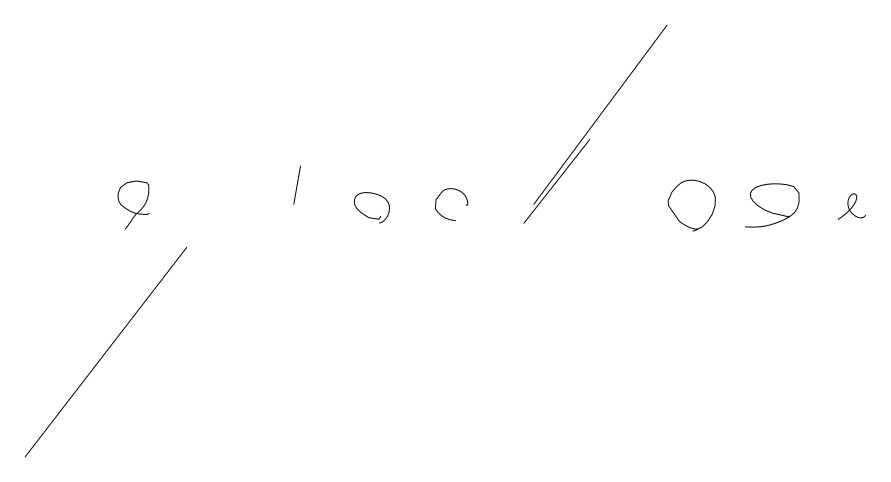

In [114]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
    reconstructions.append([decode(temperature=0.1, draw_mode=False), [0, i]])


stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

In [84]:
def get_model_params():
    # get trainable params.
    model_names = []
    model_params = []
    model_shapes = []
    with sess.as_default():
        t_vars = tf.trainable_variables()
        for var in t_vars:
            param_name = var.name
            p = sess.run(var)
            model_names.append(param_name)
            params = p
            model_params.append(params)
            model_shapes.append(p.shape)
    return model_params, model_shapes, model_names


def quantize_params(params, max_weight=10.0, factor=32767):
    result = []
    max_weight = np.abs(max_weight)
    for p in params:
        r = np.array(p)
        r /= max_weight
        r[r > 1.0] = 1.0
        r[r < -1.0] = -1.0
        result.append(np.round(r * factor).flatten().astype(np.int).tolist())
    return result


In [85]:
model_params, model_shapes, model_names = get_model_params()

In [86]:
model_names

['vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_xh:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_hh:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_gamma:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_beta:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_gamma:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_beta:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_xh:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_hh:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_gamma:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_beta:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_gamma:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_beta:0',
 'vector_rnn/ENC_RNN_mu/super_linear_w:0',
 'vector_rnn/ENC_RNN_mu/super_linear_b:0',
 'vector_rnn/ENC_RNN_sigma/super_linear_w:0',
 'vector_rnn/ENC_RNN_sigma/super_linear_b:0',
 'vector_rnn/linear/super_linear_w:0',
 'vector_rnn/linear/super_linear_b:0',
 'vector_rnn/RNN/output_w:0',
 'vector_rnn/RNN/output_b:

In [87]:
# scale factor converts "model-coordinates" to "pixel coordinates" for your JS canvas demo later on.
# the larger it is, the larger your drawings (in pixel space) will be.
# I recommend setting this to 100.0 and iterating the value in the json file later on when you build the JS part.
scale_factor = 200.0
metainfo = {"mode":2,"version":6,"max_seq_len":train_set.max_seq_length,"name":"{}".format(subject),"scale_factor":scale_factor}

In [88]:
model_params_quantized = quantize_params(model_params)

In [89]:
model_blob = [metainfo, model_shapes, model_params_quantized]

In [90]:
with open("{}.gen.full.json".format(subject), 'w') as outfile:
    json.dump(model_blob, outfile, separators=(',', ':'))


After you dump the `custom.gen.full.json`, you should save the below code as `compress_model.json`, and run:

```
node compress_model.js custom.gen.full.json custom.gen.json
```

To get to the final file you can use for Sketch-RNN-JS

Below is the entire code for `compress_model.js` which will be run using node:

```
/*
compress_model.js
Compress JSON model to b64 encoded version to save bandwidth. only works for decoder-only sketch-rnn model.
*/

const assert = require('assert');
const fs = require('fs');

/**
 * deals with decompressing b64 models to float arrays.
 */
function btoa(s) {
  return Buffer.from(s, 'binary').toString('base64');
}
function string_to_uint8array(b64encoded) {
  var u8 = new Uint8Array(atob(b64encoded).split("").map(function(c) {
    return c.charCodeAt(0); }));
  return u8;
}
function uintarray_to_string(u8) {
  var s = "";
  for (var i = 0, len = u8.length; i < len; i++) {
    s += String.fromCharCode(u8[i]);
  }
  var b64encoded = btoa(s);
  return b64encoded;
};
function string_to_array(s) {
  var u = string_to_uint8array(s);
  var result = new Int16Array(u.buffer);
  return result;
};
function array_to_string(a) {
  var u = new Uint8Array(a.buffer);
  var result = uintarray_to_string(u);
  return result;
};

var args = process.argv.slice(2);

try {
  assert.strictEqual(args.length, 2);
} catch (err) {
  console.log("Usage: node compress_model.js orig_full_model.json compressed_model.json")
  process.exit(1);
}

var orig_file = args[0];
var target_file = args[1];

var orig_model = JSON.parse(fs.readFileSync(orig_file, 'ascii'));

var model_weights = orig_model[2];
var compressed_weights = [];

for (var i=0;i<model_weights.length;i++) {
  compressed_weights.push(array_to_string(new Int16Array(model_weights[i])));
}

var target_model = [orig_model[0], orig_model[1], compressed_weights];

fs.writeFileSync(target_file, JSON.stringify(target_model), 'ascii');
```